# Plot ROC Curves for Structure Damage Classification with different endmember libraries
<strong>Plot ROC curves to evaluate CAF, dCAF, and dNBR for classifying structures in the Eaton Fire area as (1) Destroyed or (0) No Damage.</strong>

<strong>Building polygons:</strong> OpenStreetMap shapefiles downloaded from [here](https://download.geofabrik.de/north-america/us/california/socal.html)

<strong>Structure damage:</strong> DINS database [here](https://gis.data.cnra.ca.gov/datasets/CALFIRE-Forestry::cal-fire-damage-inspection-dins-data/explore?location=34.211734%2C-118.040860%2C11.86)

*Only* structures labeled either “Not Damaged” or “Destroyed” by DINS are included in this analysis. Structures labeled  “Affected” or “Minor Damage” are excluded.

Total structures loaded: 14945
Structures after clipping to raster extent: 14928

Number of NaN values before cleaning:
  DamageCode: 0
  Mark_Median: 4
  CAF_Median: 4
  Francisco_Median: 4
  BoBLocal_CAF_Median: 4
  Local_CAF_Median: 4

Structures included in final analysis: 14924
Original CAF Only ROC Analysis:
AUC: 0.9243
Youden’s J: 0.7449 at threshold 0.6893
    TPR: 0.8825, FPR: 0.1376
Min Distance to (0,1): 0.1807 at threshold 0.6905
    TPR: 0.8802, FPR: 0.1354


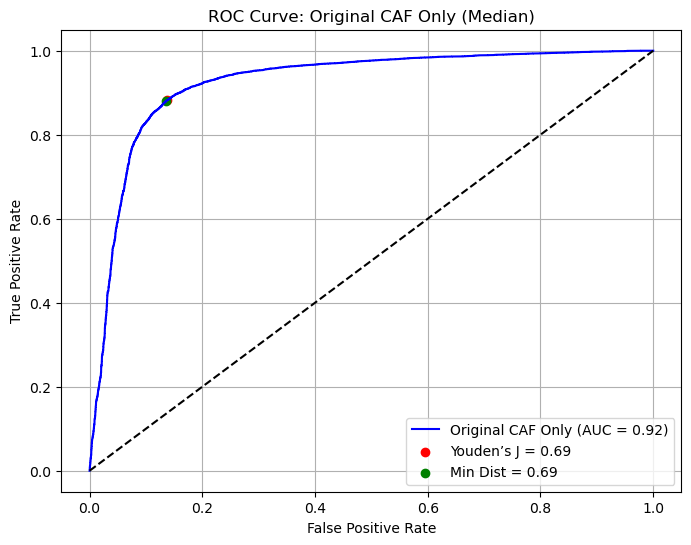

Local CAF Only (Francisco's Picks) ROC Analysis:
AUC: 0.8577
Youden’s J: 0.6024 at threshold 0.7097
    TPR: 0.8540, FPR: 0.2516
Min Distance to (0,1): 0.2832 at threshold 0.7267
    TPR: 0.8180, FPR: 0.2169


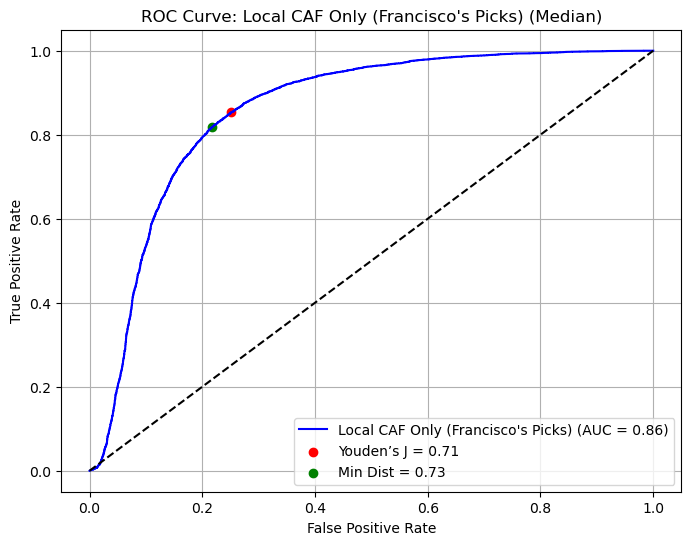

10 Local Best of Both + Original ROC Analysis:
AUC: 0.9313
Youden’s J: 0.7567 at threshold 0.7365
    TPR: 0.8804, FPR: 0.1236
Min Distance to (0,1): 0.1720 at threshold 0.7365
    TPR: 0.8804, FPR: 0.1236


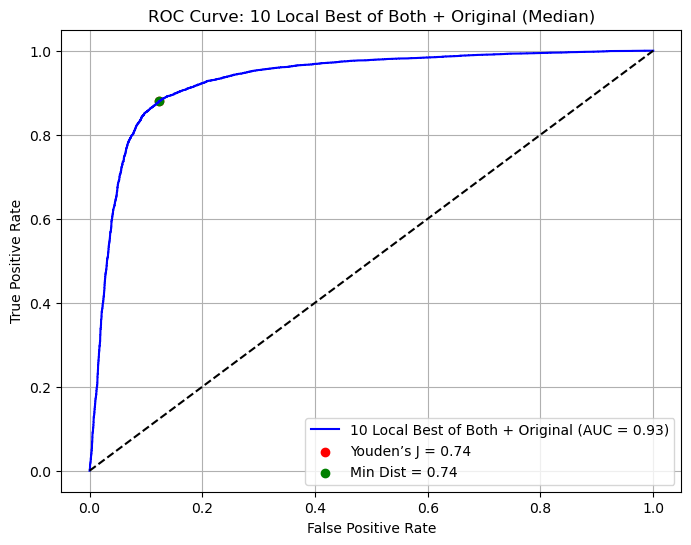

Francisco's Picks + Original ROC Analysis:
AUC: 0.8868
Youden’s J: 0.6489 at threshold 0.7346
    TPR: 0.8455, FPR: 0.1966
Min Distance to (0,1): 0.2501 at threshold 0.7346
    TPR: 0.8455, FPR: 0.1966


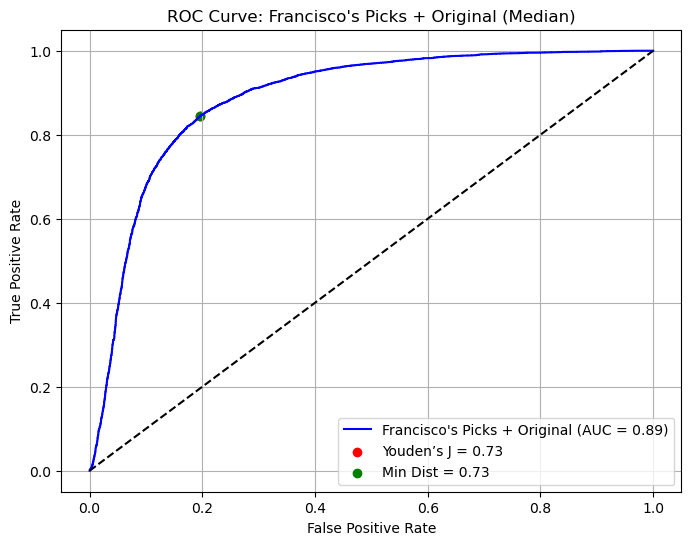

Mark's Picks + Original ROC Analysis:
AUC: 0.9070
Youden’s J: 0.7006 at threshold 0.7351
    TPR: 0.8699, FPR: 0.1693
Min Distance to (0,1): 0.2132 at threshold 0.7367
    TPR: 0.8667, FPR: 0.1664


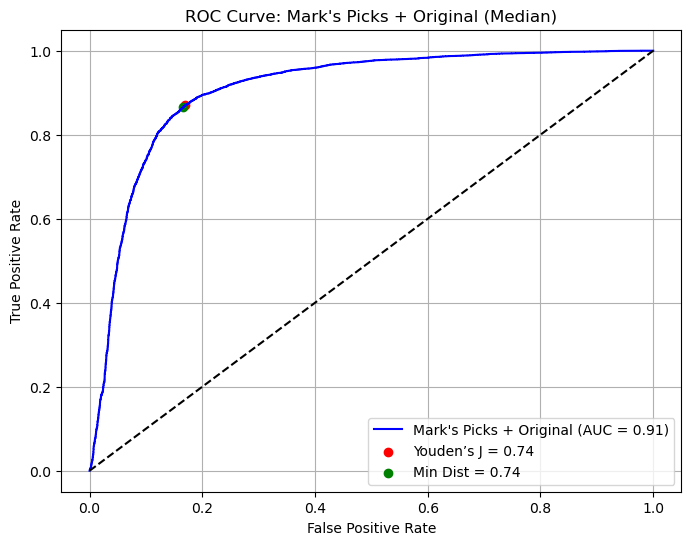

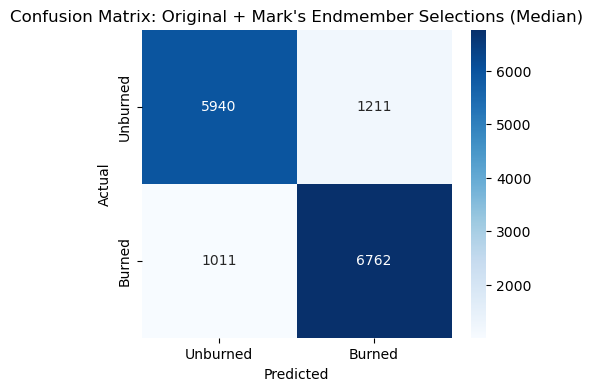


Classification Report for Original + Mark's Endmember Selections (Median):

              precision    recall  f1-score   support

    Unburned       0.85      0.83      0.84      7151
      Burned       0.85      0.87      0.86      7773

    accuracy                           0.85     14924
   macro avg       0.85      0.85      0.85     14924
weighted avg       0.85      0.85      0.85     14924



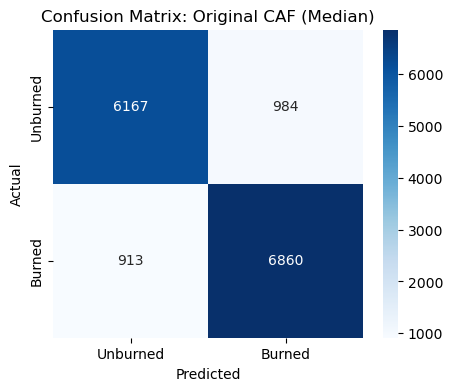


Classification Report for Original CAF (Median):

              precision    recall  f1-score   support

    Unburned       0.87      0.86      0.87      7151
      Burned       0.87      0.88      0.88      7773

    accuracy                           0.87     14924
   macro avg       0.87      0.87      0.87     14924
weighted avg       0.87      0.87      0.87     14924



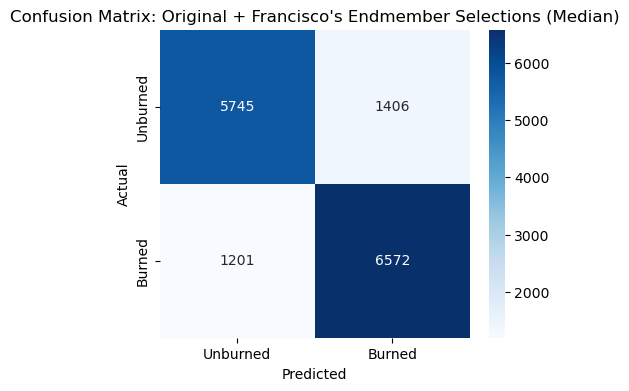


Classification Report for Original + Francisco's Endmember Selections (Median):

              precision    recall  f1-score   support

    Unburned       0.83      0.80      0.82      7151
      Burned       0.82      0.85      0.83      7773

    accuracy                           0.83     14924
   macro avg       0.83      0.82      0.82     14924
weighted avg       0.83      0.83      0.83     14924



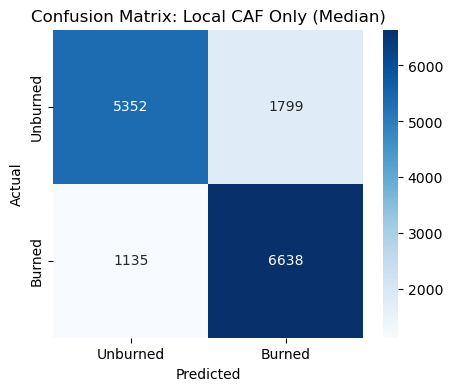


Classification Report for Local CAF Only (Median):

              precision    recall  f1-score   support

    Unburned       0.83      0.75      0.78      7151
      Burned       0.79      0.85      0.82      7773

    accuracy                           0.80     14924
   macro avg       0.81      0.80      0.80     14924
weighted avg       0.81      0.80      0.80     14924



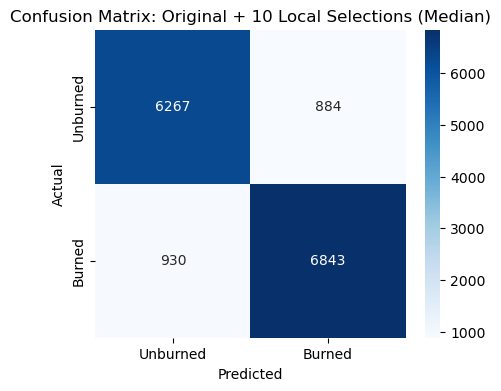


Classification Report for Original + 10 Local Selections (Median):

              precision    recall  f1-score   support

    Unburned       0.87      0.88      0.87      7151
      Burned       0.89      0.88      0.88      7773

    accuracy                           0.88     14924
   macro avg       0.88      0.88      0.88     14924
weighted avg       0.88      0.88      0.88     14924



In [1]:
import geopandas as gpd
import rasterio
from shapely.geometry import box
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# ------------------------------
# Load Data
# ------------------------------

# Load structure polygons
structures = gpd.read_file("/Volumes/One_Touch/Palisades_Eaton_Fire_ArcGIS/Structures_EatonFire/DINS_building_SpatialJoin.shp")

# Load rasters 
tif_path_Mark = "/Volumes/GEOG/Structure_classification/julia-unmixing/output_fractional_cover_band2/addlocalizedMarkspicks_output_band2-AV3_Eaton_structures__fractional_cover.tif" #original + Mark's local picks
tif_path_caf = "/Volumes/GEOG/Structure_classification/julia-unmixing/output_fractional_cover_band2/output_band2-AV3_Eaton_structures__fractional_cover.tif" #original library
tif_path_Francisco = "/Volumes/GEOG/Structure_classification/julia-unmixing/output_fractional_cover_band2/addlocalized_output_band2-AV3_Eaton_structures__fractional_cover.tif" #original + Francisco's local picks
tif_path_local_caf = "/Volumes/GEOG/Structure_classification/julia-unmixing/output_fractional_cover_band2/localized_output_band2-AV3_Eaton_structures__fractional_cover.tif" #local library only (Francisco's local picks)
tif_path_BoBlocal_caf = "/Volumes/GEOG/Structure_classification/julia-unmixing/output_fractional_cover_band2/BoB-addlocalized_output_band2-AV3_Eaton_structures__fractional_cover.tif" #Best of Both + original (Francisco's & Mark's matching local picks)


with rasterio.open(tif_path_Mark) as src:
    raster_bounds = src.bounds
    raster_bbox = box(*raster_bounds)
    raster_gdf = gpd.GeoDataFrame({"geometry": [raster_bbox]}, crs=structures.crs)

# Clip structures to raster extent (but do NOT buffer)
structures_clipped = gpd.clip(structures, raster_gdf)

# ------------------------------
# Zonal Stats: Median
# ------------------------------

# Francisco's selections added to original
with rasterio.open(tif_path_Francisco) as src:
    Francisco_nodata = src.nodata
Francisco_stats = zonal_stats(
    structures_clipped, tif_path_Francisco,
    stats="median", geojson_out=True,
    nodata=Francisco_nodata
)
structures_clipped["Francisco_Median"] = [stat["properties"]["median"] for stat in Francisco_stats]

# CAF
with rasterio.open(tif_path_caf) as src:
    caf_nodata = src.nodata
caf_stats = zonal_stats(
    structures_clipped, tif_path_caf,
    stats="median", geojson_out=True,
    nodata=caf_nodata
)
structures_clipped["CAF_Median"] = [stat["properties"]["median"] for stat in caf_stats]

# Mark's selections added to original
with rasterio.open(tif_path_Mark) as src:
    Mark_nodata = src.nodata
Mark_stats = zonal_stats(
    structures_clipped, tif_path_Mark,
    stats="median", geojson_out=True,
    nodata=Mark_nodata
)
structures_clipped["Mark_Median"] = [stat["properties"]["median"] for stat in Mark_stats]

# local_CAF
with rasterio.open(tif_path_local_caf) as src:
    local_caf_nodata = src.nodata
local_caf_stats = zonal_stats(
    structures_clipped, tif_path_local_caf,
    stats="median", geojson_out=True,
    nodata=local_caf_nodata
)
structures_clipped["Local_CAF_Median"] = [stat["properties"]["median"] for stat in local_caf_stats]

# BoB_local_CAF
with rasterio.open(tif_path_BoBlocal_caf) as src:
    BoBlocal_caf_nodata = src.nodata
BoBlocal_caf_stats = zonal_stats(
    structures_clipped, tif_path_BoBlocal_caf,
    stats="median", geojson_out=True,
    nodata=BoBlocal_caf_nodata
)
structures_clipped["BoBLocal_CAF_Median"] = [stat["properties"]["median"] for stat in BoBlocal_caf_stats]

# ------------------------------
# Inspect and Clean NaNs
# ------------------------------

print(f"Total structures loaded: {len(structures)}")
print(f"Structures after clipping to raster extent: {len(structures_clipped)}")

# Count NaNs
print("\nNumber of NaN values before cleaning:")
print("  DamageCode:", structures_clipped["DamageCode"].isna().sum())
print("  Mark_Median:", structures_clipped["Mark_Median"].isna().sum())
print("  CAF_Median:", structures_clipped["CAF_Median"].isna().sum())
print("  Francisco_Median:", structures_clipped["Francisco_Median"].isna().sum())
print("  BoBLocal_CAF_Median:", structures_clipped["BoBLocal_CAF_Median"].isna().sum())
print("  Local_CAF_Median:", structures_clipped["Local_CAF_Median"].isna().sum())


# Drop rows with any NaNs
clean_structures = structures_clipped.dropna(subset=["DamageCode", "Mark_Median", "CAF_Median", "Francisco_Median", "Local_CAF_Median", "BoBLocal_CAF_Median"])

print(f"\nStructures included in final analysis: {len(clean_structures)}")

# Extract ground reference
y_true = clean_structures["DamageCode"].astype(int)

# ------------------------------
# ROC + Optimal Thresholds
# ------------------------------

def analyze_metric(y_true, y_scores, label):
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Youden’s J statistic
    j_scores = tpr - fpr
    youden_index = np.argmax(j_scores)
    threshold_youden = thresholds[youden_index]
    
    # Distance to (0,1)
    distances = np.sqrt((1 - tpr)**2 + fpr**2)
    min_dist_index = np.argmin(distances)
    threshold_dist = thresholds[min_dist_index]
    
    # Print detailed results
    print(f"{label} ROC Analysis:")
    print(f"AUC: {roc_auc:.4f}")
    print(f"Youden’s J: {j_scores[youden_index]:.4f} at threshold {threshold_youden:.4f}")
    print(f"    TPR: {tpr[youden_index]:.4f}, FPR: {fpr[youden_index]:.4f}")
    print(f"Min Distance to (0,1): {distances[min_dist_index]:.4f} at threshold {threshold_dist:.4f}")
    print(f"    TPR: {tpr[min_dist_index]:.4f}, FPR: {fpr[min_dist_index]:.4f}")
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.scatter(fpr[youden_index], tpr[youden_index], color='red', label=f"Youden’s J = {threshold_youden:.2f}")
    plt.scatter(fpr[min_dist_index], tpr[min_dist_index], color='green', label=f"Min Dist = {threshold_dist:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {label} (Median)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return threshold_youden, threshold_dist




# Analyze CAF
threshold_caf_youden, threshold_caf_dist = analyze_metric(y_true, clean_structures["CAF_Median"], "Original CAF Only")

# Analyze Local_CAF
threshold_local_caf_youden, threshold_local_caf_dist = analyze_metric(y_true, clean_structures["Local_CAF_Median"], "Local CAF Only (Francisco's Picks)")

# Analyze BoBLocal_CAF
threshold_BoBlocal_caf_youden, threshold_BoBlocal_caf_dist = analyze_metric(y_true, clean_structures["BoBLocal_CAF_Median"], "10 Local Best of Both + Original")

# Analyze Francisco's selections added to original
threshold_Francisco_youden, threshold_Francisco_dist = analyze_metric(y_true, clean_structures["Francisco_Median"], "Francisco's Picks + Original")

# Analyze Mark's selections added to original
threshold_Mark_youden, threshold_Mark_dist = analyze_metric(y_true, clean_structures["Mark_Median"], "Mark's Picks + Original")



# ------------------------------
# Evaluate Classifications
# ------------------------------

def evaluate_model(y_true, y_pred, label):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Unburned", "Burned"], yticklabels=["Unburned", "Burned"])
    plt.title(f"Confusion Matrix: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print(f"\nClassification Report for {label}:\n")
    print(classification_report(y_true, y_pred, target_names=["Unburned", "Burned"]))

# Evaluate using Youden’s J thresholds
y_pred_Mark_youden = (clean_structures["Mark_Median"] >= threshold_Mark_youden).astype(int)
y_pred_caf_youden = (clean_structures["CAF_Median"] >= threshold_caf_youden).astype(int)
y_pred_Francisco_youden = (clean_structures["Francisco_Median"] >= threshold_Francisco_youden).astype(int)
y_pred_local_caf_youden = (clean_structures["Local_CAF_Median"] >= threshold_local_caf_youden).astype(int)
y_pred_BoBlocal_caf_youden = (clean_structures["BoBLocal_CAF_Median"] >= threshold_BoBlocal_caf_youden).astype(int)

# Evaluate using Min Distance thresholds
y_pred_Mark_dist = (clean_structures["Mark_Median"] >= threshold_Mark_dist).astype(int)
y_pred_caf_dist = (clean_structures["CAF_Median"] >= threshold_caf_dist).astype(int)
y_pred_Francisco_dist = (clean_structures["Francisco_Median"] >= threshold_Francisco_dist).astype(int)
y_pred_local_caf_dist = (clean_structures["Local_CAF_Median"] >= threshold_local_caf_dist).astype(int)
y_pred_BoBlocal_caf_dist = (clean_structures["BoBLocal_CAF_Median"] >= threshold_BoBlocal_caf_dist).astype(int)

# Evaluate Model

y_pred_Mark = y_pred_Mark_youden
y_pred_caf = y_pred_caf_youden
y_pred_Francisco = y_pred_Francisco_youden
y_pred_local_caf = y_pred_local_caf_youden
y_pred_BoBlocal_caf = y_pred_BoBlocal_caf_youden

evaluate_model(y_true, y_pred_Mark, "Original + Mark's Endmember Selections (Median)")
evaluate_model(y_true, y_pred_caf, "Original CAF (Median)")
evaluate_model(y_true, y_pred_Francisco, "Original + Francisco's Endmember Selections (Median)")
evaluate_model(y_true, y_pred_local_caf, "Local CAF Only (Median)")
evaluate_model(y_true, y_pred_BoBlocal_caf, "Original + 10 Local Selections (Median)")

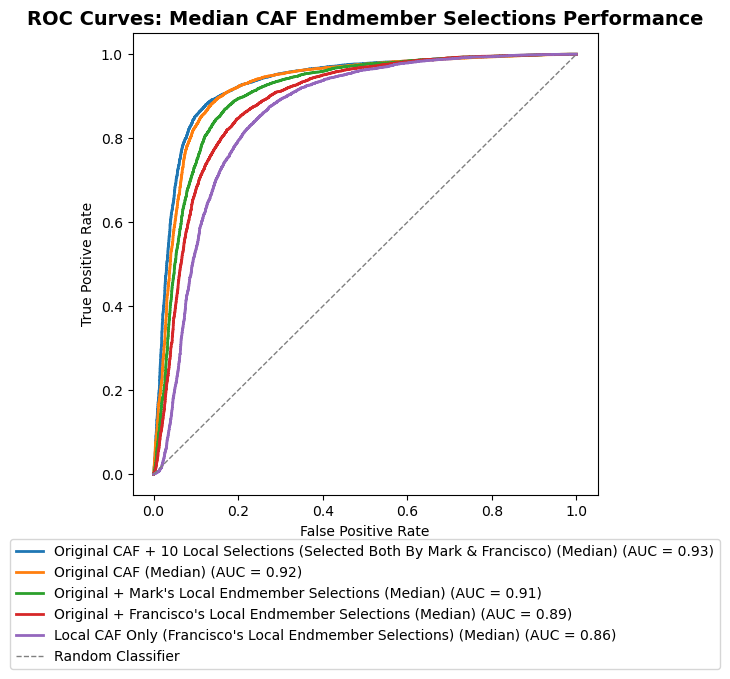

In [2]:

# Plot figure for paper

def plot_combined_roc(y_true, y_scores_dict, title="Combined ROC Curve"):
    """
    Plot multiple ROC curves on the same plot.

    Parameters:
    - y_true: Ground reference binary labels
    - y_scores_dict: Dictionary where keys are labels and values are prediction scores
    - title: Title of the plot
    """
    plt.figure(figsize=(6, 6))

    for label, y_scores in y_scores_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

    # Add diagonal line for random classifier
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1, label="Random Classifier")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title, fontsize=14, fontweight="bold")
    # Put a legend below current axis
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True)
    #plt.grid(True)
    plt.show()

plot_combined_roc(
    y_true,
    {
        "Original CAF + 10 Local Selections (Selected Both By Mark & Francisco) (Median)": clean_structures["BoBLocal_CAF_Median"],
        "Original CAF (Median)": clean_structures["CAF_Median"],
        "Original + Mark's Local Endmember Selections (Median)": clean_structures["Mark_Median"],
        "Original + Francisco's Local Endmember Selections (Median)": clean_structures["Francisco_Median"],
        "Local CAF Only (Francisco's Local Endmember Selections) (Median)": clean_structures["Local_CAF_Median"]
        
    },
    title="ROC Curves: Median CAF Endmember Selections Performance"
)

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_rel
import pandas as pd
import numpy as np
import itertools

# --------------------------
# Define metrics to evaluate
# --------------------------
metric_names = [
    "CAF_Median", \
    "Mark_Median", "Francisco_Median",
    "Local_CAF_Median", "BoBLocal_CAF_Median"
]

# Matrix of AUCs: one list per metric
auc_scores = {name: [] for name in metric_names}

X = clean_structures[metric_names].values
y = y_true.values

# 10-fold Stratified CV
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_idx, test_idx in kf.split(X, y):
    y_test = y[test_idx]
    for i, name in enumerate(metric_names):
        scores = X[test_idx, i]
        auc = roc_auc_score(y_test, scores)
        auc_scores[name].append(auc)

# --------------------------
# Summary table
# --------------------------
summary_df = pd.DataFrame({
    "Metric": metric_names,
    "Mean AUC": [np.mean(auc_scores[name]) for name in metric_names],
    "Std Dev": [np.std(auc_scores[name]) for name in metric_names]
})

# --------------------------
# Paired t-tests
# --------------------------
def sig_star(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "n.s."

comparisons = []
for m1, m2 in itertools.combinations(metric_names, 2):
    t_stat, p_val = ttest_rel(auc_scores[m1], auc_scores[m2])
    comparisons.append({
        "Comparison": f"{m1} vs {m2}",
        "p-value": p_val,
        "Significance": sig_star(p_val)
    })

comparison_table = pd.DataFrame(comparisons)

# --------------------------
# Print Results
# --------------------------
print("=== Mean AUC and Std Dev ===")
print(summary_df.to_string(index=False))

print("\n=== Paired t-test Comparisons ===")
print(comparison_table.to_string(index=False))


=== Mean AUC and Std Dev ===
             Metric  Mean AUC  Std Dev
         CAF_Median  0.924325 0.008275
        Mark_Median  0.906828 0.010352
   Francisco_Median  0.886899 0.008976
   Local_CAF_Median  0.857831 0.011010
BoBLocal_CAF_Median  0.931419 0.007994

=== Paired t-test Comparisons ===
                             Comparison      p-value Significance
              CAF_Median vs Mark_Median 4.924125e-05          ***
         CAF_Median vs Francisco_Median 4.710716e-08          ***
         CAF_Median vs Local_CAF_Median 6.866079e-08          ***
      CAF_Median vs BoBLocal_CAF_Median 9.960059e-04          ***
        Mark_Median vs Francisco_Median 5.751728e-08          ***
        Mark_Median vs Local_CAF_Median 1.021621e-07          ***
     Mark_Median vs BoBLocal_CAF_Median 9.865026e-08          ***
   Francisco_Median vs Local_CAF_Median 1.364756e-06          ***
Francisco_Median vs BoBLocal_CAF_Median 1.086704e-09          ***
Local_CAF_Median vs BoBLocal_CAF_Median 1.